![image.png](plots/portada_ensemble.png)

# Introducción
___

¡Bienvenidos a la sesión de introducción a los ensembles! Un ensemble es una serie de modelos que proporcionan predicciones de forma conjunta para mejorar los resultados que cada uno, de forma individual, podría dar. 

Como bibliografía adicional para estas sesiones recomiendo:
* [Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow, 2nd Edition](https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/). Capítulo 7

Para resolver estas prácticas necesitaremos los paquetes de Python de `numpy`, `pandas`, `matplotlib` y `sklearn`, empecemos cargando estos paquetes:

In [1]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt

%matplotlib inline

np.random.seed(5) # Los resultados del notebook serán los mismos en cada ejecución

import os
num_cores = os.cpu_count()

# Ensemble básico
___

Veamos la forma más directa de construcción de un ensemble. Se basa simplemente en construir distintos modelos y obtener una predicción final en base a las predicciones de todos los modelos. Veamos un ejemplo utilizando el conjunto de datos de `moons`:

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [3]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression()
tree_clf = DecisionTreeClassifier()
svm_clf = SVC()

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('tree_clf', tree_clf), ('svc', svm_clf)],
    voting='hard')

voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression()),
                             ('tree_clf', DecisionTreeClassifier()),
                             ('svc', SVC())])

In [4]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, tree_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
DecisionTreeClassifier 0.88
SVC 0.896
VotingClassifier 0.912


Como podemos ver, el resultado del `VotingClassifier` es ligeramente superior al de los demás modelos por separado.

### <font color='D12828'> Ejercicio: </font>

* Utilizando el conjunto de datos de boston, presentado en la sesión anterior, construye un `VotingRegressor` que utilice:
    * Un modelo de regresión lineal `sklearn.linear_model.LinearRegression`
    * Una SVM de regresión `sklearn.svm.SVR`
    * Un árbol de regresión `sklearn.tree.DecisionTreeRegressor`
* Calcula el `mean_squared_error` de cada modelo, así como del `VotingRegressor`

In [5]:
from sklearn.datasets import load_boston

boston = load_boston()
x_boston = boston.data
y_boston = boston.target

x_train_boston, x_test_boston, y_train_boston, y_test_boston = train_test_split(x_boston, y_boston, train_size=0.8, random_state=5)


C:\Users\alvaromc317\miniconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing da

In [6]:
# Ejercicio
from sklearn.ensemble import VotingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

lm = LinearRegression()
tree_reg = DecisionTreeRegressor()
svm_reg = SVR()

voting_regressor = VotingRegressor(
    estimators = [('lm', lm), ('tree_reg', tree_reg), ('svm_reg', svm_reg)])

for clf in (lm, tree_reg, svm_reg, voting_regressor):
    clf.fit(x_train_boston, y_train_boston)
    y_pred = clf.predict(x_test_boston)
    print(clf.__class__.__name__, mean_squared_error(y_test_boston, y_pred))

LinearRegression 20.869292183770778
DecisionTreeRegressor 30.24843137254901
SVR 58.6325623449
VotingRegressor 17.538146790658683


# Bagging
___

Bagging es diminutivo de bootstrap aggregating. La idea detrás de estos ensembles es sencilla:

1. A partir del conjunto de entrenamiento, generar $M$ subconjuntos usando bootstrapping
2. Entrenar un modelo con cada subconjunto (esto puede hacerse en paralelo).
3. Los resultados se agregan en una predicción final:
    * Regresión: Media de todos los modelos.
    * Clasificación: Por votación a la clase mayoritaria.

Veamos un ejemplo con el conjunto de datos `moons` anterior.

In [7]:
from sklearn.ensemble import BaggingClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), 
    n_estimators=100, max_samples=0.5, n_jobs=num_cores - 1)

bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

print(accuracy_score(y_test, y_pred))

0.912


## Comparativa: Arbol vs Ensemble

En la sesión anterior veíamos que un problema de los árboles era su inestabilidad y su uso de fronteras de decisión ortogonales (perpendiculares a un eje). Utilizando ensembles, este problema se resuelve en gran medida. Veamoslo con un ejercicio:

### <font color='D12828'> Ejercicio: </font>
* En el conjunto de datos de moons `X_train`, `y_train`, entrena un único árbol de clasificación (sin modificar los hiperparámetros por defecto)
* Representa la frontera de decisión de este árbol usando las funciones `plot_decision_boundary` y `plt.scatter`
* Representa la frontera de decisión del `BaggingClassifier` entrenado antes.
* ¿Qué diferencias observas?

In [8]:
def plot_decision_boundary(clf, axes):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    plt.contourf(x1, x2, y_pred, alpha=0.3)

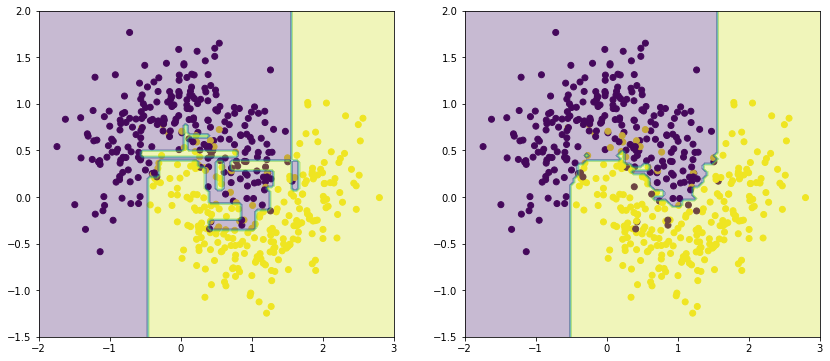

In [9]:
# Ejercicio

tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)

plt.figure(figsize=(14, 6))

plt.subplot(1,2,1)
plt.scatter(X[:,0], X[:,1], c=y)
plot_decision_boundary(tree_clf, axes=[-2, 3, -1.5, 2])

plt.subplot(1,2,2)
plt.scatter(X[:,0], X[:,1], c=y)
plot_decision_boundary(bag_clf, axes=[-2, 3, -1.5, 2])

### <font color='D12828'> Ejercicio: </font>

* Utilizando el conjunto de datos de boston, construye un `BaggingRegressor` que utilice:
* 100 árboles de regresión
* Construya los subconjuntos de bootstrapping usando 200 observaciones en cada uno
* Calcula su error cuadrático medio

In [10]:
# Ejercicio

from sklearn.ensemble import BaggingRegressor

bag_reg = BaggingRegressor(
    DecisionTreeRegressor(), 
    n_estimators=100, max_samples=200, n_jobs=num_cores - 1)

bag_reg.fit(x_train_boston, y_train_boston)

y_pred = bag_reg.predict(x_test_boston)

print(mean_squared_error(y_test_boston, y_pred))

9.122279225490196


## Evaluación Out of Bag

Al hacer bagging, algunas observaciones pueden ser seleccionadas más de una vez, mientras otras no son seleccionadas en absoluto. De esta forma, dadas n observaciones en el conjunto de datos original, si realizamos bootstrapping tomando $n$ observaciones con reemplazamiento, estaremos seleccionando aproximadamente $2/3$ del conjunto de datos original. El $1/3$ restante está "out of bag". Observa que en cada modelo, el conjunto OOB será diferente, ya que el muestreo se hace al hacer en cada modelo. Como cada modelo no ha visto ninguna observación de su conjunto OOB, este se puede usar para validar el modelo, calculando las predicciones sin necesidad de construir un conjunto de validación. Para evaluar el ensemble, simplemente debemos agregar las evaluaciones OOB de los modelos. 

Para calcular esta evaluación OOB en sklearn, debemos incluir el parámetro `oob_score=True` en nuestro `BaggingClassifier`. Veamos un ejemplo:


In [11]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=100,
    n_jobs=num_cores - 1, oob_score=True)

bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.896

También podemos obtener la evaluación OOB para cada observación utilizando la función `bag_clf.oob_decision_function_`

In [12]:
bag_clf.oob_decision_function_[0:5]

array([[0.38709677, 0.61290323],
       [0.35897436, 0.64102564],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.        , 1.        ]])

Esto nos devuelve la probabilidad de pertenencia a cada clase que nuestro ensemble asigna a cada observación del conjunto de datos. Por ejemplo, la primera observación se clasifica como 1, ya que la probabilidad de esa clase es de un 60\%

### OOB en regresión

En el caso de construir un `BaggingRegressor`, la función `oob_score_` no devuelve el error cuadrático medio, sino una estimación del coeficiente $R^2$, calculado como:

$$ R^{2}(y, \hat{y})=1-\frac{\sum_{i=1}^{n}\left(y_{i}-\hat{y}_{i}\right)^{2}}{\sum_{i=1}^{n}\left(y_{i}-\bar{y}\right)^{2}} $$

* Si las predicciones son exactas a la media de la variable respuesta, $R^2=0$
* Si las predicciones son peores que la media, $R^2<0$
* Si las predicciones son mejores que la media, $R^2>0$
* Como máximo, esta función puede tomar valor 1

### <font color='D12828'> Ejercicio: </font>

* Obtén la estimación OOB de un modelo `BaggingRegressor`  entrenado en el conjunto de datos Boston.

In [13]:
# Ejercicio

bag_reg = BaggingRegressor(
    DecisionTreeRegressor(), n_estimators=100,
    n_jobs=num_cores - 1, oob_score=True)

bag_reg.fit(x_train_boston, y_train_boston)
bag_reg.oob_score_

0.871773631732427

También podemos acceder a las predicciones hechas por el `BaggingRegressor` para cada observación del conjunto de train usando la función `bag_reg.oob_prediction_`

### <font color='D12828'> Ejercicio: </font>
* Utilizando la función `oob_prediction_` obtén el valor del error cuadrático medio de las observaciones OOB.

In [14]:
# Ejercicio

y_pred = bag_reg.oob_prediction_

print(mean_squared_error(y_train_boston, y_pred))

11.014862706960828


# Random Forest
___

Los Random Forest (RF) son el algoritmo de Bagging más conocido. Esencialmente son ensembles de bagging construidos con árboles, pero además de la aleatoriedad conseguida por el bootstrapping, añaden un extra de aleatoriedad en las variables, ya que cada arbol de un random forest se construye utilizando solo un subconjunto de las variables originales del conjunto de datos. Esto permite reducir el sobre ajuste, y reducir los tiempos de entrenamiento (ya que cada arbol usa menos variables). Un random forest tiene por tanto:
* Los hiperparámetros de los árboles
* Los hiperparámetros del bagging
* Hiperparámetros que controlan el número de variables.

Veamos un ejemplo utilizando el conjunto de datos de moon anterior:

In [15]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=200, max_depth=6, oob_score=True, n_jobs=num_cores - 1)

rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)

print(rnd_clf.oob_score_)

0.9146666666666666


### <font color='D12828'> Ejercicio: </font>
* Construye un RF de regresión en el conjunto de datos de boston

In [16]:
# Ejercicio

from sklearn.ensemble import RandomForestRegressor

rnd_reg_boston = RandomForestRegressor(n_estimators=200, max_leaf_nodes=16, n_jobs=num_cores - 1)

rnd_reg_boston.fit(x_train_boston, y_train_boston)

y_pred_rf = rnd_reg_boston.predict(x_test_boston)

print(f'MSE: {mean_squared_error(y_test_boston, y_pred_rf)}')

MSE: 12.299653187432408


## Feature importance

Los RF también proporcionan un ranking de las variables más importantes. Para cada arbol, se calcula cual es la reducción de la impureza que se consigue usando cada variable. Después se agrega la información de todos los árboles y se escala de forma que la suma de la importancia de todas las variables sea 1. Esta información se almacena en `rnd_clf.feature_importances_`. Veamos un ejemplo utilizando el conjunto de datos de iris:

<BarContainer object of 4 artists>

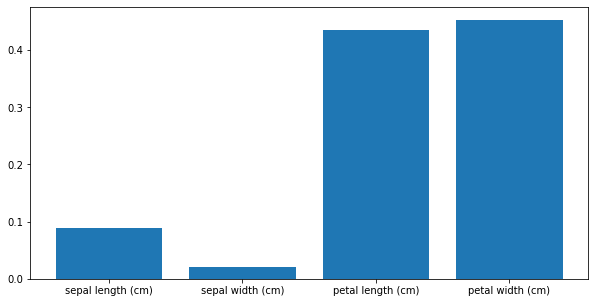

In [17]:
from sklearn.datasets import load_iris
iris = load_iris()

rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=num_cores - 1)
rnd_clf.fit(iris["data"], iris["target"])

plt.figure(figsize=(10, 5))
plt.bar(iris["feature_names"], rnd_clf.feature_importances_)

Podemos ver que las dos variables más importantes son Petal length y petal width, y que el sepal width prácticamente no aporta ninguna ganancia.

### <font color='D12828'> Ejercicio: </font>
* Obtén la importancia de las variables del conjunto de datos de boston.

<BarContainer object of 13 artists>

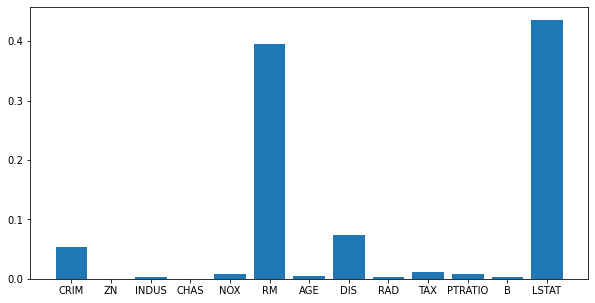

In [18]:
# Ejercicio

plt.figure(figsize=(10, 5))
plt.bar(boston["feature_names"], rnd_reg_boston.feature_importances_)

## Conjunto MNIST
Recordemos el conjunto de datos MNIST utilizado en las sesiones de introducción a las máquinas de vector soporte. Este era un conjunto formado por 70000 imágenes de dígitos escritos a mano. El objetivo en este conjunto era, dada la imagen de un dígito, identificarlo correctamente. 

In [19]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)

X, y = mnist['data'], mnist['target']

y = y.astype(np.uint8)  # Convertir y a números enteros.

print(f'Dimensiones X: {X.shape}\nDimensiones y: shape{y.shape}')

Dimensiones X: (70000, 784)
Dimensiones y: shape(70000,)


Visualicemos una de las observaciones del conjunto de datos.

Text(0.5, 1.0, '7')

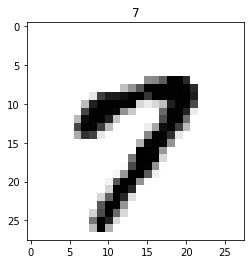

In [20]:
idx_image = 15

digit_image = X.values[idx_image,:].reshape((28, 28))
plt.imshow(digit_image, cmap='binary')
plt.title(y[idx_image])

### <font color='D12828'> Ejercicio: </font>
* Divide el conjunto de datos en una parte de train y otra de test de forma que el train_size sea 50% del total (lo habitual sería en torno al 30, pero queremos reducir el tiempo de computación)
* Utiliza Grid search para optimizar el número de nodos hoja `max_leaf_nodes` en el random forest. Define un param grid de no mas de 4 valores.
* Calcula la tasa de aciertos de tu modelo
* Almacena en un vector la importancia de las variables. 
* Utiliza la función `plt.imshow` (usada justo encima) para visualizar la importancia de las variables como una imagen de tamaño 28x28. ¿Cómo interpretas este resultado?

In [21]:
# Ejercicio

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42, stratify=y)

In [22]:
# Ejercicio

from sklearn.model_selection import GridSearchCV

param_grid = [{'max_leaf_nodes':[50, 100, 150]}]
rnd_clf = RandomForestClassifier(oob_score=True)

grid_search = GridSearchCV(rnd_clf, param_grid, cv=3, n_jobs = num_cores-1, verbose=1)
grid_search.fit(X_train, y_train)

final_model = grid_search.best_estimator_
final_model


Fitting 3 folds for each of 3 candidates, totalling 9 fits


In [23]:
# Ejercicio

predictions = final_model.predict(X_test)
accuracy_score(y_test, predictions)

0.9229428571428572

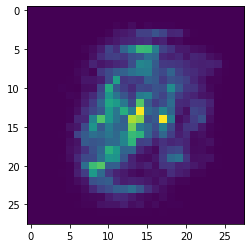

In [24]:
# Ejercicio

feature_importance = final_model.feature_importances_
plt.imshow(feature_importance.reshape((28, 28)))

# Fin
___